In [94]:
import sklearn
import warnings
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from statistics import median, mean
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,cross_val_score, cross_validate, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier,RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import RocCurveDisplay

In [6]:
dir = "data/"

employee_survey = pd.read_csv(dir + "employee_survey_data.csv")
general = pd.read_csv(dir + "general_data.csv")
manager_survey = pd.read_csv(dir + "manager_survey_data.csv")
in_time = pd.read_csv(dir + "in_time.csv")
out_time = pd.read_csv(dir + "out_time.csv")

# Sommaire

<ul>
    <li><a href="#es">Employe survey</a></li>
    <li><a href="#ge">General</a></li>
    <li><a href="#ms">Manager survey</a></li>
    <li><a href="#it">In Time</a></li>
    <li><a href="#ot">Out Time</a></li>
    <li><a href="#ld">Lien entre les dataset</a></li>
    <li><a href="#cc">Conclusion</a></li>
</ul>

# Définition des variables globales

In [7]:
nbEmploye = employee_survey["EmployeeID"].max()
print("Il y a", nbEmploye, "employés dans le dataset")

Il y a 4410 employés dans le dataset


# Employee survey
<div id="es"></div>

## Données contenues dans le set

In [8]:
employee_survey.head()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0
2,3,2.0,2.0,1.0
3,4,4.0,4.0,3.0
4,5,4.0,1.0,3.0


## Anaylse des données vides

In [9]:
employee_survey.isnull().sum()

EmployeeID                  0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
dtype: int64

## Répartition des notes

<Axes: >

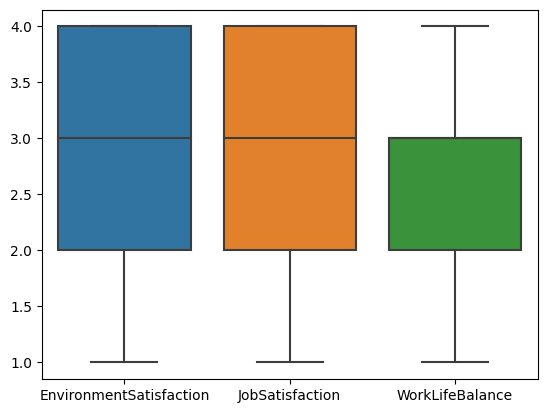

In [10]:
employee_survey_anonyme = employee_survey.drop(["EmployeeID"], axis=1, inplace=False)
sns.boxplot(data=employee_survey_anonyme)


<Axes: ylabel='Count'>

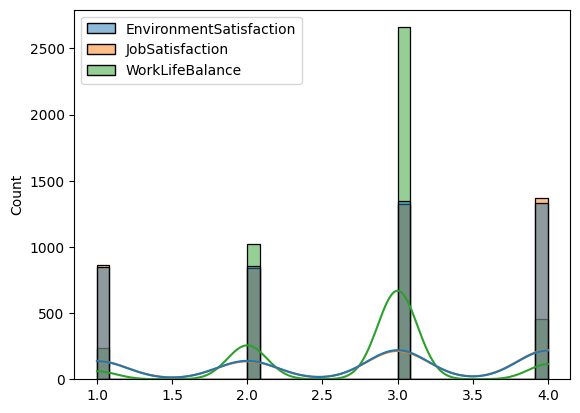

In [11]:
sns.histplot(data=employee_survey_anonyme, kde=True)

## Tendance des mauvais résultats

On regarde tout d'abord le nombre de gens qui sont insatisfait le l'environnement de travail et on remarque qu'ils représentent 38,5% des employés

In [12]:
BadEnvironmentSatisfaction = employee_survey[employee_survey['EnvironmentSatisfaction']<2.1].count()
print(BadEnvironmentSatisfaction['EnvironmentSatisfaction'] / nbEmploye * 100)
BadEnvironmentSatisfaction


38.57142857142858


EmployeeID                 1701
EnvironmentSatisfaction    1701
JobSatisfaction            1694
WorkLifeBalance            1685
dtype: int64

On fait la même chose pour la satisfaction sur leurs travail et on obtient des résultats similaires, ce qui confirme les boîtes a moustache

In [13]:
BadJobSatisfaction = employee_survey[employee_survey['JobSatisfaction']<2.1].count()
print(BadJobSatisfaction['JobSatisfaction'] / nbEmploye * 100)
BadJobSatisfaction

38.54875283446712


EmployeeID                 1700
EnvironmentSatisfaction    1694
JobSatisfaction            1700
WorkLifeBalance            1687
dtype: int64

Enfin on regarde l'équilibre entre la vie privée et professionelle, dans ce cas on obtient 28.5% des employés

In [14]:
BadWorkLifeBalance = employee_survey[employee_survey['WorkLifeBalance']<2.1].count()
print(BadWorkLifeBalance['WorkLifeBalance'] / nbEmploye * 100)
BadWorkLifeBalance

28.52607709750567


EmployeeID                 1258
EnvironmentSatisfaction    1250
JobSatisfaction            1254
WorkLifeBalance            1258
dtype: int64

Si on essaie de regarder les employés qui ont a la foie une balance mauvaise, et une satisfaction de leur travail et de leur environnement de travail faible on obtient 178 personne avec une très mauvaise expérience

In [15]:
BadEnvironmentSatisfaction = employee_survey[employee_survey['EnvironmentSatisfaction']<2.1]
BadSatisfaction = BadEnvironmentSatisfaction[BadEnvironmentSatisfaction['JobSatisfaction']<2.1]
BadAll = BadSatisfaction[BadSatisfaction['WorkLifeBalance']<2.1]
BadAll["EmployeeID"].count()

178

# General
<div id="ge"></div>

## Données contenue dans le set

In [16]:
general.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


## Analyse des données vides

In [17]:
general.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

## Modifications nécéssaires

### Variables discrètes hierarchiques

Ensuite, on remplace les valeurs dans "BusinessTravel" avec l'"OrdinalEncoder" car il y a un ordre hiérarchique entre les données

In [19]:
ord_enc = OrdinalEncoder(categories=[['Non-Travel','Travel_Rarely','Travel_Frequently']])
encoded = ord_enc.fit_transform(general[["BusinessTravel"]])
general.drop('BusinessTravel', axis=1)
general = general.assign(BusinessTravel = encoded) 

In [20]:
ord_enc = OrdinalEncoder(categories=[['No','Yes']])
encoded = ord_enc.fit_transform(general[["Attrition"]])
general.drop('Attrition', axis=1)
general = general.assign(Attrition = encoded) 

In [21]:
ord_enc = OrdinalEncoder(categories=[['N','Y']])
encoded = ord_enc.fit_transform(general[["Over18"]])
general.drop('Over18', axis=1)
general = general.assign(Over18 = encoded) 

### Variables discrètes indépendantes
Ensuite on remplace les valeurs dans "Department" avec le "OneHotEncoder" car il n'y a pas de hiérarchie entre les valeurs

In [22]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['Department']])
dpt_enc = pd.DataFrame(encoded.toarray())
dpt_enc = dpt_enc.rename(columns={0:'Department_HR', 1:'Department_Research & Development', 2:'Department_Sales'})
general.drop('Department', axis=1, inplace=True)
general = pd.concat([general, dpt_enc], axis=1)

In [23]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['EducationField']])
edu_enc = pd.DataFrame(encoded.toarray())
edu_enc = edu_enc.rename(columns={
    0:'Education_Human Resources', 
    1:'Education_Life Sciences', 
    2:'Education_Marketing', 
    3:'Education_Medical', 
    4:'Education_Other', 
    5:'Education_Technical Degreee'})
general.drop('EducationField', axis=1, inplace=True)
general = pd.concat([general, edu_enc], axis=1)

In [24]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['Gender']])
gen_enc = pd.DataFrame(encoded.toarray())
gen_enc = gen_enc.rename(columns={0:'Female', 1:'Male'})
general.drop('Gender', axis=1, inplace=True)
general = pd.concat([general, gen_enc], axis=1)


In [25]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['JobRole']])
job_enc = pd.DataFrame(encoded.toarray())
job_enc = job_enc.rename(columns={
    0:'Job_Healthcare Representative', 
    1:'Job_Human Resources', 
    2:'Job_Laboratory Technician', 
    3:'Job_Manager', 
    4:'Job_Manufacturing Director',
    5:'Job_Research Director',
    6:'Job_Research Scientist',
    7:'Job_Sales Executive',
    8:'Job_Sales Representative'})
general.drop('JobRole', axis=1, inplace=True)
general = pd.concat([general, job_enc], axis=1)

In [26]:
one_enc = OneHotEncoder()
encoded = one_enc.fit_transform(general[['MaritalStatus']])
mar_enc = pd.DataFrame(encoded.toarray())
mar_enc = mar_enc.rename(columns={0:'Divorced', 1:'Married', 2:'Single'})
general.drop('MaritalStatus', axis=1, inplace=True)
general = pd.concat([general, mar_enc], axis=1)

La classe globale encoder fait strictement la même chose que les cellules précédentes a ceci près qu'elle peu être intégré au pipeline

In [27]:
class global_encoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None

    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, data):
        bus_enc = self.ordinal_encode(data['BusinessTravel'])
        data.drop(["BusinessTravel"], axis=1, inplace=True)
        att_enc = self.ordinal_encode(data['Attrition'])
        data.drop(["Attrition"], axis=1, inplace=True)
        ove_enc = self.ordinal_encode(data['Over18'])
        data.drop(["Over18"], axis=1, inplace=True)

        mar_enc = self.one_hot_encode(data['MaritalStatus'])
        data.drop(["MaritalStatus"], axis=1, inplace=True)
        dep_enc = self.one_hot_encode(data['Department'])
        data.drop(["Department"], axis=1, inplace=True)
        edu_enc = self.one_hot_encode(data['EducationField'])
        data.drop(["EducationField"], axis=1, inplace=True)
        job_enc = self.one_hot_encode(data['JobRole'])
        data.drop(["JobRole"], axis=1, inplace=True)
        gen_enc = self.one_hot_encode(data['Gender'])
        data.drop(["Gender"], axis=1, inplace=True)

        return pd.concat([data, mar_enc, bus_enc, att_enc, ove_enc, dep_enc, edu_enc, job_enc, gen_enc], axis=1)


    def one_hot_encode(self, column):
        one_enc = OneHotEncoder()
        encoded = one_enc.fit_transform(column)
        df_enc = pd.DataFrame(encoded.toarray())
        return df_enc.rename(columns=column.unique())
    
    def ordinal_encode(self, column):
        ord_enc = OrdinalEncoder(categories=column.unique())
        encoded = ord_enc.fit_transform(column)
        return pd.DataFrame(encoded.toarray())
        


In [28]:
general

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,Over18,...,Job_Laboratory Technician,Job_Manager,Job_Manufacturing Director,Job_Research Director,Job_Research Scientist,Job_Sales Executive,Job_Sales Representative,Divorced,Married,Single
0,51,0.0,1.0,6,2,1,1,131160,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,31,1.0,2.0,10,1,2,1,41890,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,32,0.0,2.0,17,4,3,4,193280,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,38,0.0,0.0,2,5,4,3,83210,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,32,0.0,1.0,10,1,5,1,23420,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,0.0,1.0,5,4,4406,1,60290,3.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4406,29,0.0,1.0,2,4,4407,1,26790,2.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4407,25,0.0,1.0,25,2,4408,2,37020,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4408,42,0.0,1.0,18,2,4409,1,23980,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Analyse générales

### Nombres de personnes qui ont quitté l'entreprise en 2016

In [29]:
peopleLeft = general[general["Attrition"] == 1]
print("Number of people who left the company:", peopleLeft.shape[0], "out of", general.shape[0], "employees")
print("Approx", round(peopleLeft.shape[0] / general.shape[0] * 100, 2), "% of the employees left the company")

Number of people who left the company: 711 out of 4410 employees
Approx 16.12 % of the employees left the company


### Heatmap

Grâce a cette HeatMap on remarque qu'il n'y a pas de réel corrélation significative entre les gens qui s'en vont et leurs situations

<Axes: >

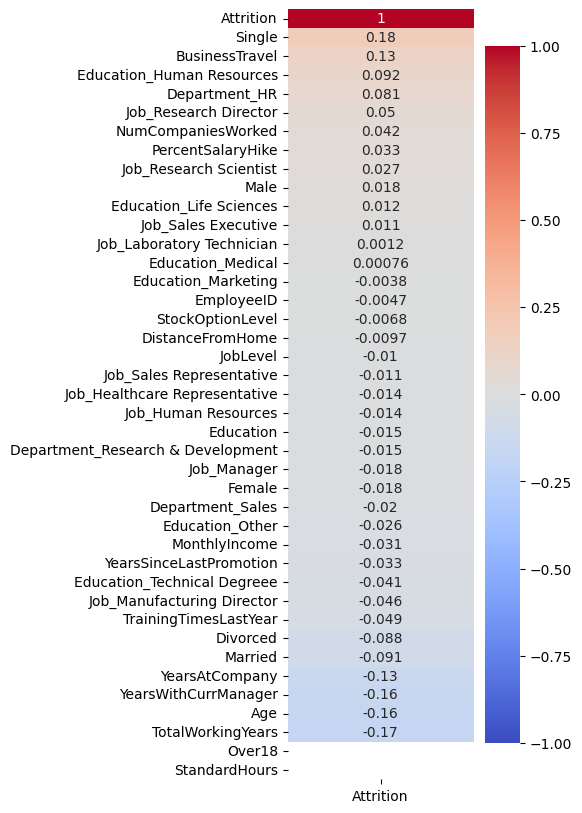

In [30]:
plt.figure(figsize=(3, 10))
general_corr = general.corr()
sns.heatmap(general_corr[['Attrition']].sort_values(by=['Attrition'],ascending=False), vmin=-1, vmax=1, annot=True, cmap='coolwarm')

### Histogrammes

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'DistanceFromHome'}>,
        <Axes: title={'center': 'Education'}>],
       [<Axes: title={'center': 'JobLevel'}>,
        <Axes: title={'center': 'MonthlyIncome'}>,
        <Axes: title={'center': 'NumCompaniesWorked'}>],
       [<Axes: title={'center': 'PercentSalaryHike'}>,
        <Axes: title={'center': 'TotalWorkingYears'}>,
        <Axes: title={'center': 'TrainingTimesLastYear'}>],
       [<Axes: title={'center': 'YearsAtCompany'}>,
        <Axes: title={'center': 'YearsSinceLastPromotion'}>,
        <Axes: title={'center': 'YearsWithCurrManager'}>]], dtype=object)

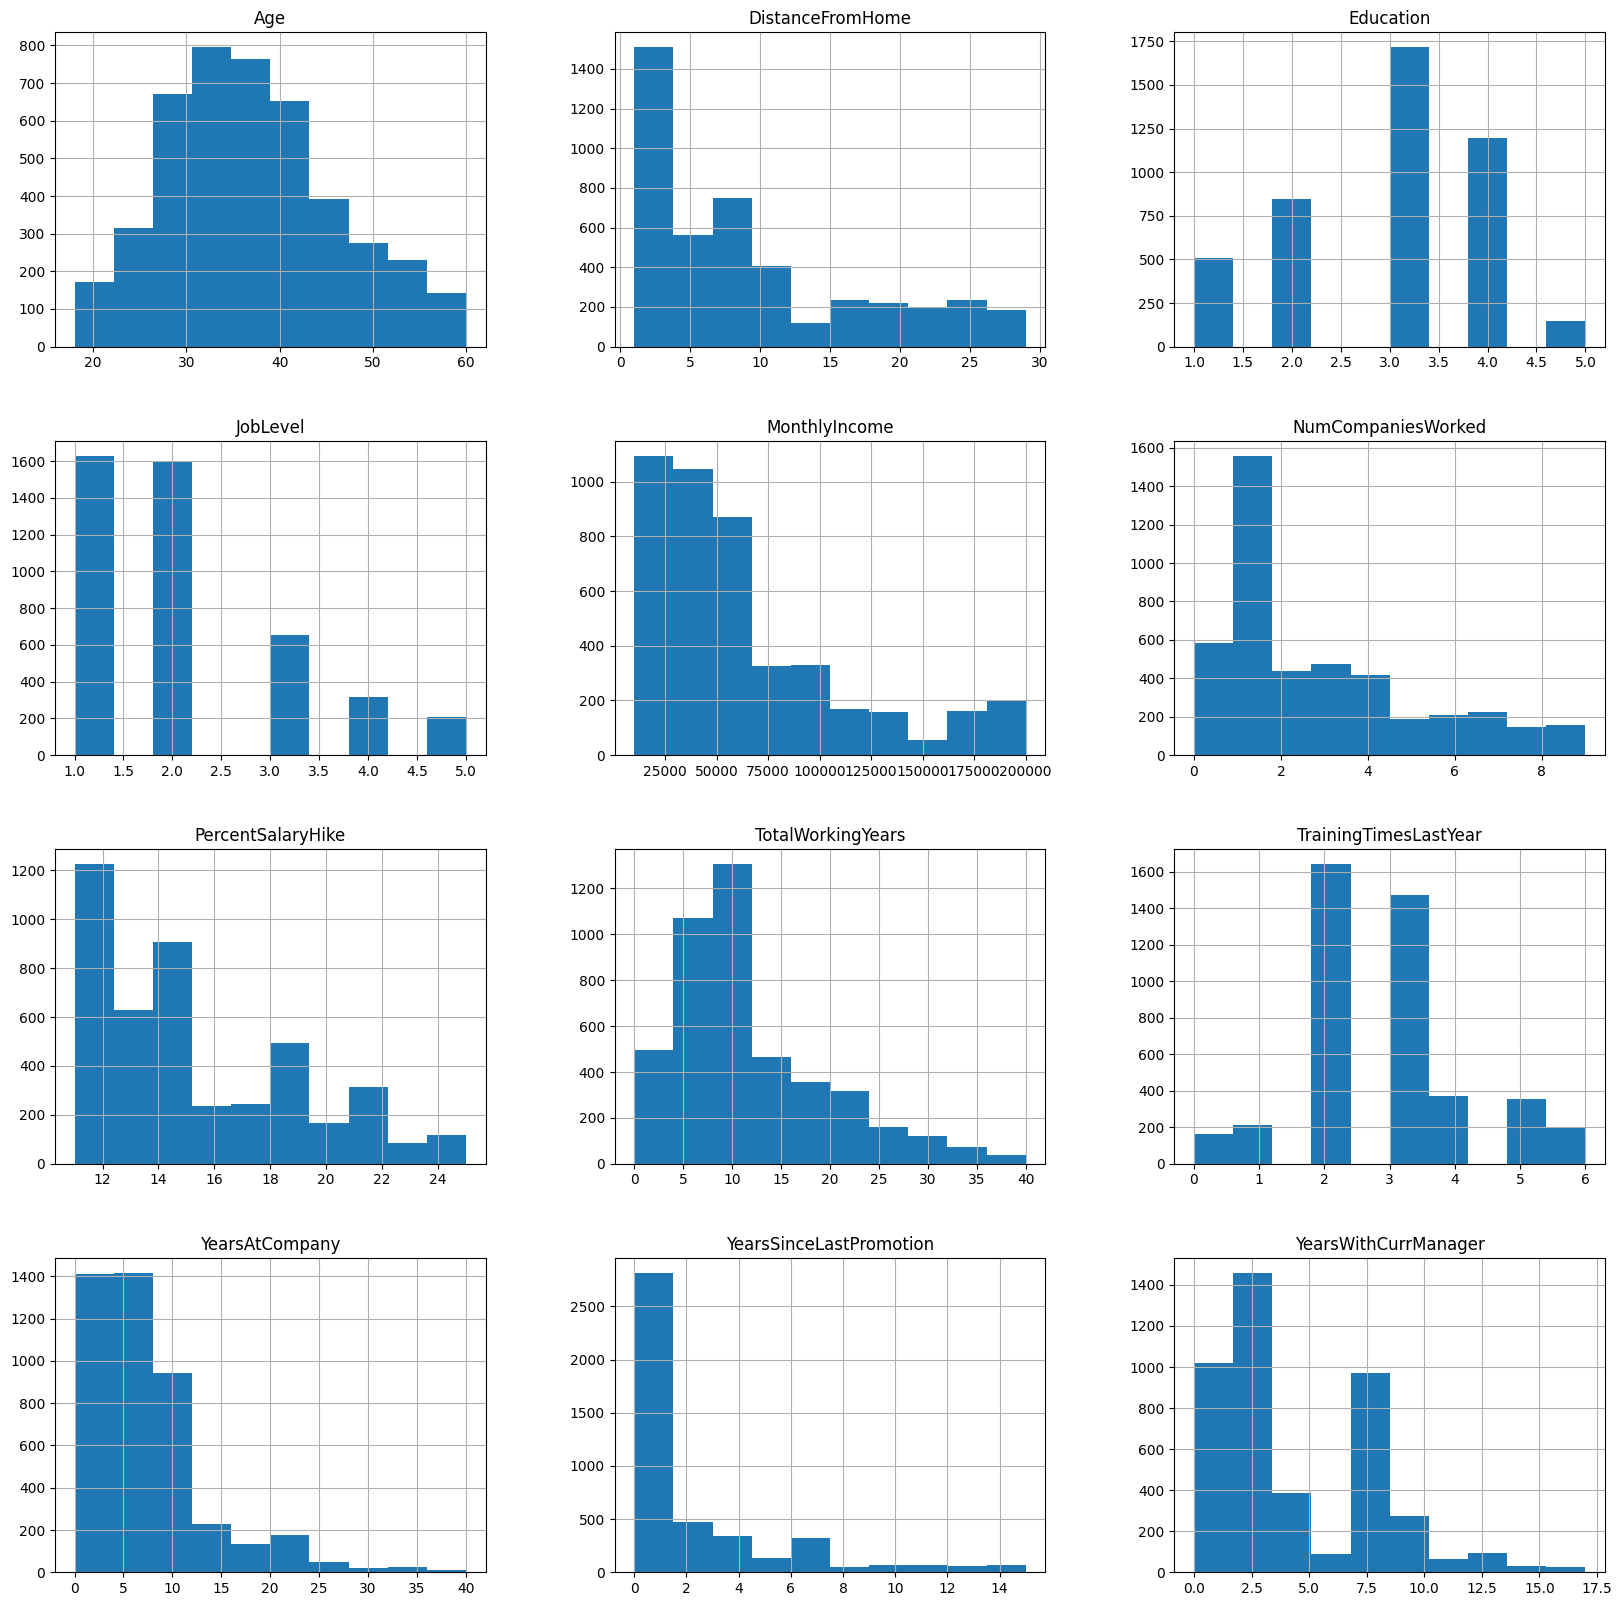

In [31]:
general.filter(items= ["Age","DistanceFromHome","Education","JobLevel", "MonthlyIncome", "NumCompaniesWorked", "PercentSalaryHike", "TotalWorkingYears", "TrainingTimesLastYear", "YearsAtCompany", "YearsSinceLastPromotion", "YearsWithCurrManager"]).hist(figsize=(20,20))

# Manager survey
<div id="ms"></div>

## Données contenue dans le set

In [32]:
manager_survey.head()

,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3
3,4,2,3
4,5,3,3


## Analyse des données vides

In [33]:
manager_survey.isnull().sum()

EmployeeID           0
JobInvolvement       0
PerformanceRating    0
dtype: int64

## Analyse générale

<Axes: >

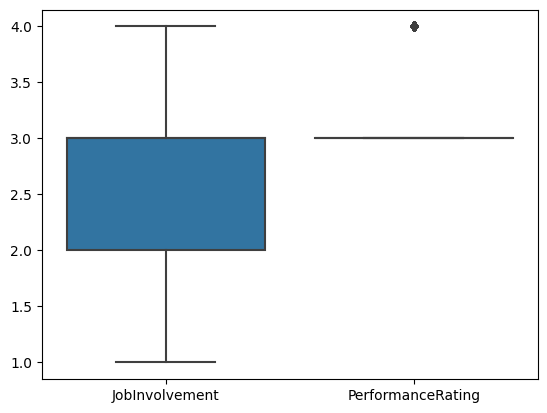

In [34]:
manager_survey_anonyme = manager_survey.drop(["EmployeeID"], axis=1, inplace=False)
sns.boxplot(data=manager_survey_anonyme)

#corréler avec attrition

# In Time
<div id="it"></div>

## Données contenues dans le dataset

In [35]:
in_time.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaN,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaN,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaN,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09


## Analyse des données vides

In [36]:
print("Par date")
print(in_time.isnull().sum())
print("Par employé")
print(in_time.isnull().sum(axis=1))

Par date
Unnamed: 0       0
2015-01-01    4410
2015-01-02     209
2015-01-05     206
2015-01-06     228
              ... 
2015-12-25    4410
2015-12-28     234
2015-12-29     230
2015-12-30     265
2015-12-31     213
Length: 262, dtype: int64
Par employé
0       29
1       25
2       19
3       26
4       16
        ..
4405    18
4406    20
4407    30
4408    20
4409    29
Length: 4410, dtype: int64


## Répartition des données

<Axes: >

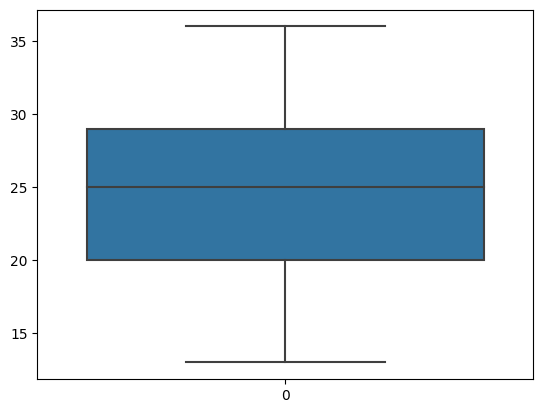

In [37]:

sns.boxplot(in_time.isnull().sum(axis=1))

# Out Time
<div id="ot"></div>

## Données contenues dans le set

In [38]:
out_time.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,...,NaN,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaN,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
1,2,NaN,2015-01-02 18:22:17,2015-01-05 17:48:22,NaN,2015-01-07 17:09:06,2015-01-08 17:34:04,2015-01-09 16:52:29,2015-01-12 17:36:48,2015-01-13 18:00:13,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaN,NaN,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
2,3,NaN,2015-01-02 16:59:14,2015-01-05 17:06:46,2015-01-06 16:38:32,2015-01-07 16:33:21,2015-01-08 17:24:22,2015-01-09 16:57:30,2015-01-12 17:28:54,2015-01-13 17:21:25,...,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,NaN,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50
3,4,NaN,2015-01-02 17:25:24,2015-01-05 17:14:03,2015-01-06 17:07:42,2015-01-07 16:32:40,2015-01-08 16:53:11,2015-01-09 17:19:47,2015-01-12 17:13:37,2015-01-13 17:11:45,...,2015-12-18 17:55:23,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,NaN,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14
4,5,NaN,2015-01-02 18:31:37,2015-01-05 17:49:15,2015-01-06 17:26:25,2015-01-07 17:37:59,2015-01-08 17:59:28,2015-01-09 17:44:08,2015-01-12 18:51:21,2015-01-13 18:14:58,...,2015-12-18 17:52:48,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,NaN,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14


## Analyse des données vides

In [39]:
print("Par date")
print(out_time.isnull().sum())
print("Par employé")
print(out_time.isnull().sum(axis=1))


Par date
Unnamed: 0       0
2015-01-01    4410
2015-01-02     209
2015-01-05     206
2015-01-06     228
              ... 
2015-12-25    4410
2015-12-28     234
2015-12-29     230
2015-12-30     265
2015-12-31     213
Length: 262, dtype: int64
Par employé
0       29
1       25
2       19
3       26
4       16
        ..
4405    18
4406    20
4407    30
4408    20
4409    29
Length: 4410, dtype: int64


## Répartition des données

<Axes: >

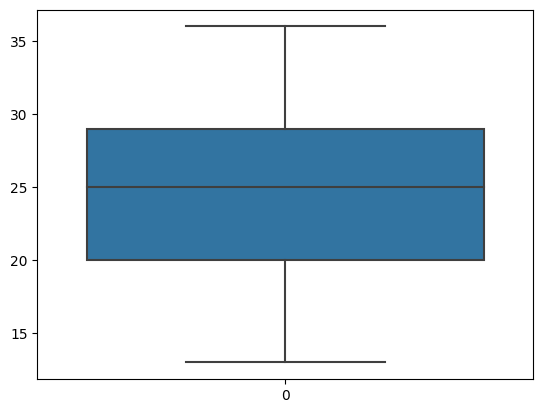

In [40]:

sns.boxplot(in_time.isnull().sum(axis=1))

# Lien entre des datasets
<div id="ld"></div>

## Données générales

### Base du temps

In [41]:
dayOff = in_time.isnull().sum() == 4410
print("Il y a", dayOff.sum() ,"jours de congés" )

Il y a 12 jours de congés


<Axes: >

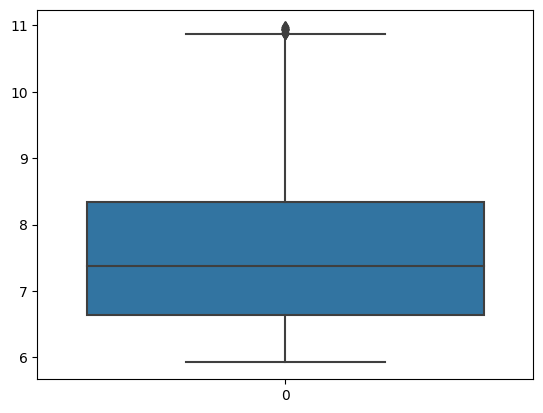

In [42]:
# average of the number of hours worked per day
in_time = in_time.dropna(axis=1, how='all')
out_time = out_time.dropna(axis=1, how='all')
in_time = in_time.dropna(axis=0, how='all')
out_time = out_time.dropna(axis=0, how='all')
in_time = in_time.apply(pd.to_datetime)
out_time = out_time.apply(pd.to_datetime)
hours_worked = out_time - in_time
hours_worked = hours_worked.applymap(lambda x: x.total_seconds() / 3600)
hours_worked = hours_worked.mean(axis=1)
hours_worked = hours_worked.dropna()
hours_worked = hours_worked.reset_index(drop=True)
sns.boxplot(hours_worked)



In [43]:
hours_worked_df = pd.DataFrame({
    "EmployeeID": general["EmployeeID"],
    "avg_hours_worked": hours_worked })
hours_worked_df

,EmployeeID,avg_hours_worked
0,1,7.342004
1,2,7.686399
2,3,6.984379
3,4,7.163197
4,5,7.973629
...,...,...
4405,4406,8.487350
4406,4407,6.067777
4407,4408,7.673414
4408,4409,9.453369


On remarque un taux plus élevé de démissions chez les gens qui travaillent le plus

<Axes: xlabel='avg_hours_worked', ylabel='Count'>

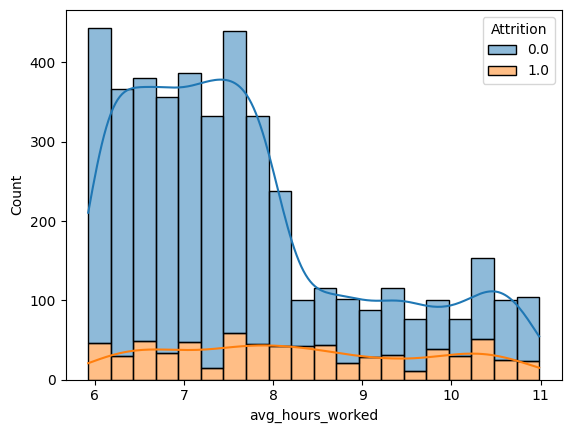

In [44]:
general_time = general.merge(hours_worked_df, on="EmployeeID")

sns.histplot(data=general_time, x="avg_hours_worked", hue="Attrition", multiple="stack", bins=20, kde=True)

In [45]:
general_badAll = general_time.merge(BadAll, on="EmployeeID", copy=True)

(general_badAll["Attrition"] == 0).sum()

133

In [46]:
out_timeAverage = out_time[out_time.columns[1:]].apply(pd.to_datetime)
out_timeAverage = out_timeAverage.apply(lambda x: (x - x.dt.normalize()).dt.total_seconds() / 3600)
out_timeAverage  = out_timeAverage.mean(axis=1)
out_timeAverage = out_timeAverage.to_frame()
out_timeAverage = out_timeAverage.assign(EmployeeID=range(1, len(out_timeAverage)+1))
out_timeAverage = out_timeAverage.rename(columns={0: 'avg_out_time'})

In [47]:
in_timeAverage = in_time[in_time.columns[1:]].apply(pd.to_datetime)
in_timeAverage = in_timeAverage.apply(lambda x: (x - x.dt.normalize()).dt.total_seconds() / 3600)
in_timeAverage = in_timeAverage.mean(axis=1)
in_timeAverage = in_timeAverage.to_frame()
in_timeAverage = in_timeAverage.assign(EmployeeID=range(1, len(in_timeAverage)+1))
in_timeAverage = in_timeAverage.rename(columns={0:'AverageStartTime'})

In [51]:
all_data = general.merge(manager_survey, on="EmployeeID", copy=True)
all_data = all_data.merge(employee_survey, on="EmployeeID", copy=True)
all_data = all_data.merge(hours_worked_df, on="EmployeeID", copy=True)
all_data = all_data.merge(out_timeAverage, on="EmployeeID", copy=True)
all_data = all_data.merge(in_timeAverage, on="EmployeeID", copy=True)

In [49]:
print(all_data["EmployeeID"].unique())
print(all_data["Over18"].unique())
print(all_data["StandardHours"].unique())

[   1    2    3 ... 4408 4409 4410]
[1.]
[8]


In [52]:
def dataCleaning(all_data, type):
    if type == 1:
        # drop useless columns
        all_data.drop("EmployeeID", axis=1, inplace=True)
        all_data.drop("Over18", axis=1, inplace=True)
        all_data.drop("EmployeeCount", axis=1, inplace=True)
        all_data.drop("StandardHours", axis=1, inplace=True)

    if type == 2:
        # drop unethical columns
        all_data.drop("Male", axis=1, inplace=True)
        all_data.drop("Female", axis=1, inplace=True)
        all_data.drop("Single", axis=1, inplace=True)
        all_data.drop("Married", axis=1, inplace=True)
        all_data.drop("Divorced", axis=1, inplace=True)
        all_data.drop("Age", axis=1, inplace=True)

    return all_data

all_data = dataCleaning(all_data,1)

<Axes: >

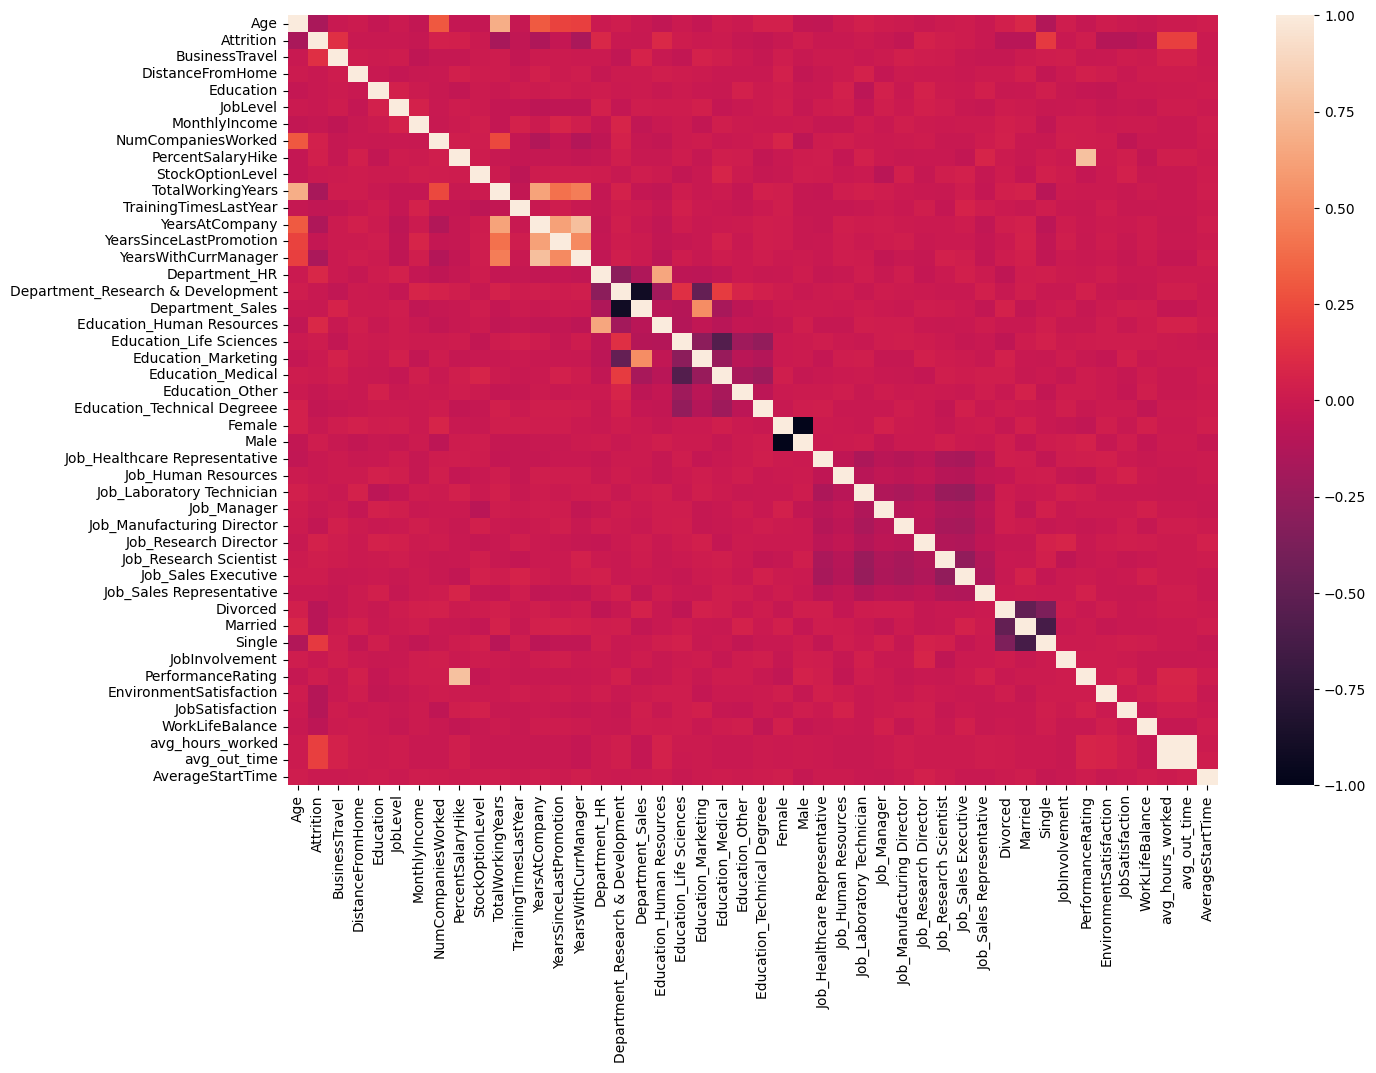

In [53]:
plt.figure(figsize=(15, 10))
sns.heatmap(all_data.corr(numeric_only=True))

<Axes: >

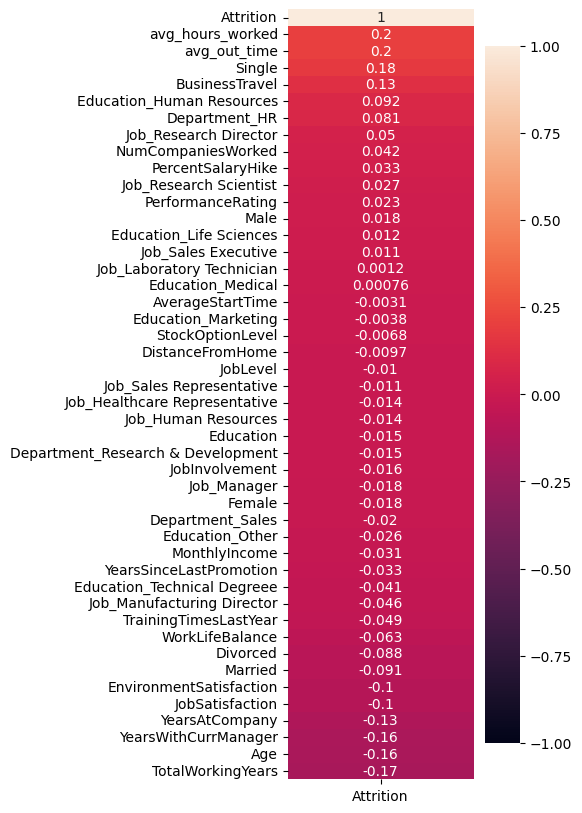

In [54]:
plt.figure(figsize=(3, 10))
all_data_corr = all_data.corr()
sns.heatmap(all_data_corr[['Attrition']].sort_values(by=['Attrition'],ascending=False), vmin=-1, vmax=1, annot=True)

Lien entre age et temps travaillé

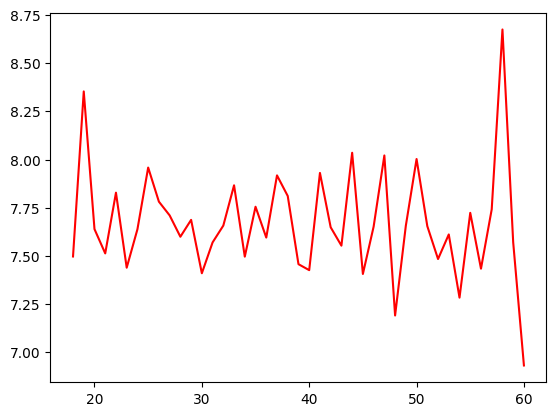

In [55]:
age_hours_worked = all_data.groupby(['Age'])["avg_hours_worked"].mean()
plt.plot(age_hours_worked.index, age_hours_worked.values, color="red")

In [56]:
all_data = dataCleaning(all_data,2)

# Gestion des valeurs manquantes

In [57]:
def nullToMedian(all_data):
    all_data["NumCompaniesWorked"] = all_data["NumCompaniesWorked"].replace(np.nan,median(all_data["NumCompaniesWorked"]))
    all_data["TotalWorkingYears"] = all_data["TotalWorkingYears"].replace(np.nan,median(all_data["TotalWorkingYears"]))

    all_data["EnvironmentSatisfaction"] = all_data["EnvironmentSatisfaction"].replace(np.nan,median(all_data["EnvironmentSatisfaction"]))
    all_data["JobSatisfaction"] = all_data["JobSatisfaction"].replace(np.nan,median(all_data["JobSatisfaction"]))
    all_data["WorkLifeBalance"] = all_data["WorkLifeBalance"].replace(np.nan,median(all_data["WorkLifeBalance"]))
    return all_data

def nullToKnnImputer(all_data):
    imputer = KNNImputer(n_neighbors=5)
    all_data_imputed = pd.DataFrame(imputer.fit_transform(all_data), columns=all_data.columns)
    return all_data_imputed

all_data = nullToMedian(all_data)

# Selection des caractéristiques

Le test du khi2 permet d'identifier les caractéristiques les plus pertinentes pour un modèle en évaluant leur indépendance par rapport à la variable cible.

In [93]:
# Préparer les données
y = all_data["Attrition"]
X = all_data.drop(columns=["Attrition"])

# Diviser les données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [96]:
# Sélection des caractéristiques avec le test du khi2
k_best = SelectKBest(chi2, k="all")  # Utilisez un nombre approprié pour 'k' en fonction de vos données
X_train_kbest = k_best.fit_transform(x_train, y_train)
X_test_kbest = k_best.transform(x_test)

In [97]:
# Choisir un modèle (ici, nous utilisons la régression logistique)
model = LogisticRegression()

# Liste pour stocker les scores de validation croisée
cv_scores = []

In [99]:
max_features = x_train.shape[1]

# Boucle sur différentes valeurs de k
for k in range(1, max_features + 1):
    # Sélection des k meilleures caractéristiques
    k_best = SelectKBest(chi2, k=k)
    X_train_kbest = k_best.fit_transform(x_train, y_train)
    
    # Évaluation du modèle avec validation croisée k-fold (k = 5)
    scores = cross_val_score(model, X_train_kbest, y_train, cv=5)
    mean_score = np.mean(scores)
    cv_scores.append(mean_score)

# Trouver la valeur de k avec la meilleure performance
best_k = np.argmax(cv_scores) + 1
print(f"La meilleure valeur de k est {best_k}")

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

La meilleure valeur de k est 29


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Nous avons donc déterminé que la valeur optimale de k est 29, nous garderons donc les 29 caractéristiques les plus importantes. Déterminons maintenant nos données finales à utiliser dans nos modèles.

In [106]:
# Sélection des caractéristiques avec le test du khi2
k_best = SelectKBest(chi2, k=29)
X_train_kbest = k_best.fit_transform(x_train, y_train)
X_test_kbest = k_best.transform(x_test)

In [105]:
# Transformation des données de test et d'entrainement en dataframe
x_train = pd.DataFrame(X_train_kbest)
x_test = pd.DataFrame(X_test_kbest)

# Mise en place des modèles

In [69]:
def score(model, x_train, y_train):
    print("Accuracy:", cross_val_score(model, x_train, y_train, cv=7, scoring='accuracy').mean())
    print("F1 score:", cross_val_score(model, x_train, y_train, cv=7, scoring='f1').mean())
    print("Precision:", cross_val_score(model, x_train, y_train, cv=7, scoring='precision').mean())
    print("Recall:", cross_val_score(model, x_train, y_train, cv=7, scoring='recall').mean())
    print("ROC AUC score:", cross_val_score(model, x_train, y_train, cv=7, scoring='roc_auc').mean())

    fig, ax = plt.subplots(figsize=(8, 6))
    RocCurveDisplay.from_estimator(dtc, x_test, y_test, ax=ax)
    plt.show()

## Choix des hyperparamètres

### DecisionTreeClassifier

Pour le DecisionTreeClassifier nous allons utiliser GridSearch afin de trouver les meilleurs hyperparamètres

In [61]:
pipeline_dtc = Pipeline(steps=[
    ('classifier', DecisionTreeClassifier())
])

In [62]:
criterion = ['gini', 'entropy']
max_depth = [16,18,20,21,22,23,24]
splitter = ['best','random']


parameters_dtc = dict(classifier__criterion=criterion,
                  classifier__max_depth=max_depth,
                  classifier__splitter=splitter)


In [63]:
dtc_GS = GridSearchCV(pipeline_dtc, parameters_dtc, cv=7)
dtc_GS.fit(x_train, y_train)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [16, 18, 20, 21, 22, 23, 24],
                         'classifier__splitter': ['best', 'random']})

In [64]:
pd.DataFrame.from_dict(dtc_GS.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
13,0.013699,0.001045,0.002808,0.000380,gini,24,random,"{'classifier__criterion': 'gini', 'classifier_...",0.970149,0.979478,0.977612,0.973832,0.996262,0.992523,0.986916,0.982396,0.009024,1
25,0.012758,0.001430,0.002177,0.000340,entropy,23,random,"{'classifier__criterion': 'entropy', 'classifi...",0.972015,0.977612,0.986940,0.971963,0.985047,0.988785,0.981308,0.980524,0.006377,2
23,0.011892,0.000808,0.002218,0.000365,entropy,22,random,"{'classifier__criterion': 'entropy', 'classifi...",0.949627,0.977612,0.979478,0.983178,0.998131,0.981308,0.990654,0.979998,0.014054,3
21,0.012544,0.001141,0.002146,0.000226,entropy,21,random,"{'classifier__criterion': 'entropy', 'classifi...",0.979478,0.973881,0.986940,0.977570,0.975701,0.986916,0.970093,0.978654,0.005899,4
11,0.013136,0.001381,0.002294,0.000365,gini,23,random,"{'classifier__criterion': 'gini', 'classifier_...",0.972015,0.972015,0.985075,0.971963,0.985047,0.975701,0.986916,0.978390,0.006453,5


Accuracy: 0.9698538349640317
F1 score: 0.9242045592818628
Precision: 0.9200348879196694
Recall: 0.9470729751403368
ROC AUC score: 0.9665457866015282


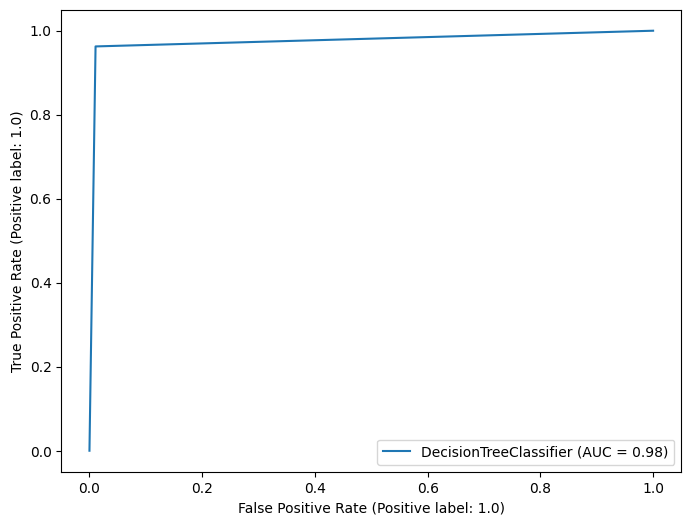

In [70]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=20, splitter="random")

dtc.fit(x_train, y_train)

score(dtc, x_train, y_train)

Après plusieurs tests, on ressort qu'une max_depth de 22 et un criterion en entropy est le meilleur model que l'on peu avoir

In [71]:
y_pred_dtc = dtc.predict(x_test)

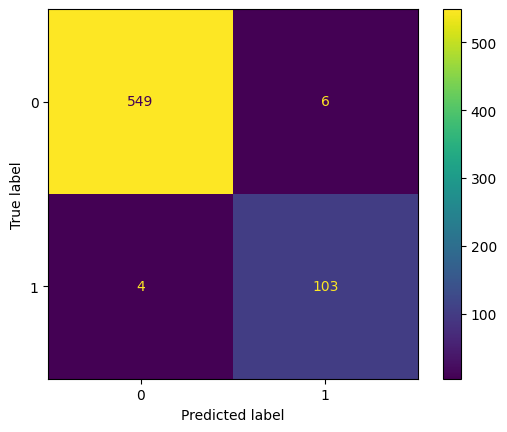

In [73]:
dtc_cm = confusion_matrix(y_test, y_pred_dtc)
dtc_cmd = ConfusionMatrixDisplay(confusion_matrix=dtc_cm,
                       display_labels=[0,1])

dtc_cmd.plot()
plt.show()


### HistGradientBoostingClassifier

In [74]:
pipeline_hgbc = Pipeline(steps=[
    ('classifier', HistGradientBoostingClassifier())
])

In [75]:
learning_rate = [0.1,0.2]
max_depth = [10,15,20]
loss = ['log_loss']
max_iter = [10,20,50,100]

parameters_hgbc = dict(classifier__learning_rate=learning_rate,
                  classifier__max_depth=max_depth,
                  classifier__loss=loss,
                  classifier__max_iter=max_iter
                  )

In [76]:
hgbc_GS = GridSearchCV(pipeline_hgbc, parameters_hgbc)
hgbc_GS.fit(x_train, y_train)

c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'auto' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\s

GridSearchCV(estimator=Pipeline(steps=[('classifier',
                                        HistGradientBoostingClassifier())]),
             param_grid={'classifier__learning_rate': [0.1, 0.2],
                         'classifier__loss': ['auto', 'binary_crossentropy'],
                         'classifier__max_depth': [10, 15, 20],
                         'classifier__max_iter': [10, 20, 50, 100]})

In [77]:
pd.DataFrame.from_dict(hgbc_GS.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__loss,param_classifier__max_depth,param_classifier__max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
39,1.449409,0.116096,0.008125,0.001359,0.2,binary_crossentropy,10,100,"{'classifier__learning_rate': 0.2, 'classifier...",0.981333,0.989333,0.986667,0.990654,0.981308,0.985859,0.003922,1
27,1.961655,0.299938,0.013044,0.003508,0.2,auto,10,100,"{'classifier__learning_rate': 0.2, 'classifier...",0.981333,0.989333,0.986667,0.990654,0.981308,0.985859,0.003922,1
43,1.519691,0.231018,0.007817,0.001579,0.2,binary_crossentropy,15,100,"{'classifier__learning_rate': 0.2, 'classifier...",0.976000,0.984000,0.988000,0.987984,0.987984,0.984794,0.004660,3
31,1.742523,0.213299,0.008424,0.000800,0.2,auto,15,100,"{'classifier__learning_rate': 0.2, 'classifier...",0.976000,0.984000,0.988000,0.987984,0.987984,0.984794,0.004660,3
47,1.644652,0.129363,0.009228,0.001922,0.2,binary_crossentropy,20,100,"{'classifier__learning_rate': 0.2, 'classifier...",0.970667,0.985333,0.984000,0.991989,0.990654,0.984529,0.007567,5


c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is e

Accuracy: 0.9903981427973619


c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is e

F1 score: 0.9692612185172222


c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is e

Precision: 0.9895945583400116


c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is e

Recall: 0.9503952342765494


c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is e

ROC AUC score: 0.9907863720385354


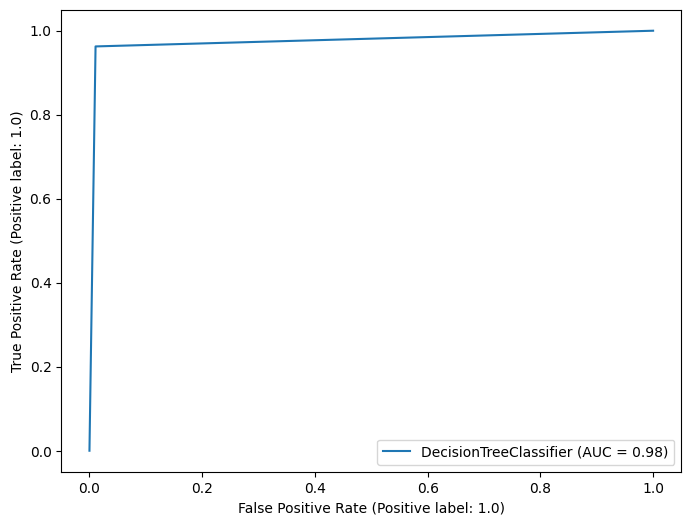

In [78]:
hgbc = HistGradientBoostingClassifier(learning_rate=0.2, max_depth=20, max_iter=100, loss="log_loss")

hgbc.fit(x_train, y_train)

score(hgbc, x_train, y_train)

In [79]:
y_pred_hgbc = hgbc.predict(x_test)

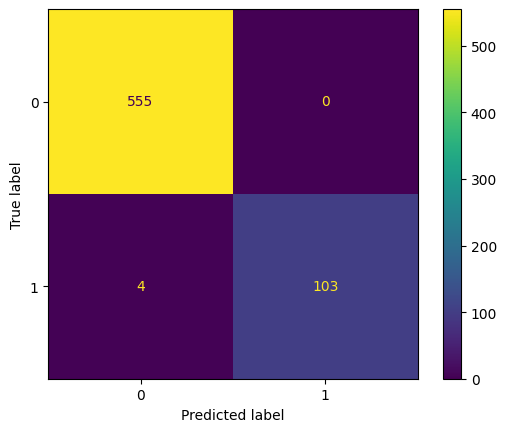

In [80]:
cm_hgbc = confusion_matrix(y_test, y_pred_hgbc)
cmd_hgbc = ConfusionMatrixDisplay(confusion_matrix=cm_hgbc,
                       display_labels=[0,1])

cmd_hgbc.plot()
plt.show()

### RandomForestClassifier

In [81]:
pipeline_rfc = Pipeline(steps=[
    ('classifier', RandomForestClassifier())
])

In [82]:
n_estimators = [1,2,3,5,10,50,100,200,300]
criterion = ['gini', 'entropy']
max_depth = [5,10,14,18,22,24,30,50,100]


parameters_rfc = dict(classifier__n_estimators=n_estimators,
                  classifier__criterion=criterion,
                  classifier__max_depth=max_depth
                  )

In [83]:
rfc_GS = GridSearchCV(pipeline_rfc, parameters_rfc)
rfc_GS.fit(x_train, y_train)

In [ ]:
pd.DataFrame.from_dict(rfc_GS.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__criterion,param_classifier__max_depth,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
134,0.970936,0.009245,0.034431,0.000490,entropy,24,300,"{'classifier__criterion': 'entropy', 'classifi...",0.970667,0.974667,0.980000,0.986649,0.978638,0.978124,0.005367,1
71,0.851593,0.015599,0.034832,0.000400,gini,50,300,"{'classifier__criterion': 'gini', 'classifier_...",0.972000,0.973333,0.978667,0.985314,0.979973,0.977857,0.004806,2
124,0.661505,0.009284,0.024422,0.001021,entropy,22,200,"{'classifier__criterion': 'entropy', 'classifi...",0.970667,0.973333,0.980000,0.987984,0.977303,0.977857,0.005994,2
125,0.995405,0.032687,0.036033,0.001266,entropy,22,300,"{'classifier__criterion': 'entropy', 'classifi...",0.972000,0.973333,0.978667,0.985314,0.978638,0.977590,0.004718,4
62,0.839066,0.005761,0.034632,0.000490,gini,30,300,"{'classifier__criterion': 'gini', 'classifier_...",0.969333,0.972000,0.976000,0.989319,0.979973,0.977325,0.006998,5


In [ ]:
rfc = RandomForestClassifier(n_estimators=300,criterion='entropy',max_depth=24)

rfc.fit(x_train, y_train)

score(rfc, x_train, y_train)

Accuracy: 0.9861287687065341
F1 score: 0.954795389514403
Precision: 0.9926325540611255
Recall: 0.9155878871195631
ROC AUC score: 0.9956636570467179


In [ ]:
y_pred_rfc = rfc.predict(x_test)

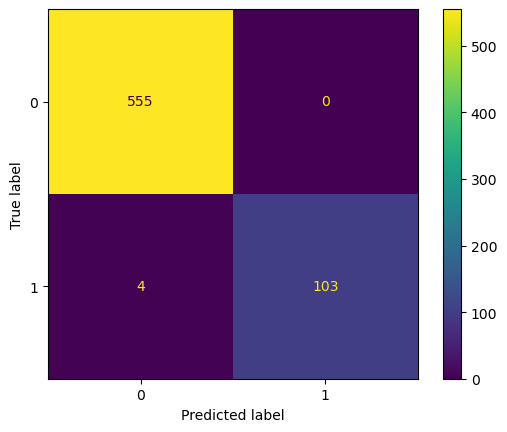

In [ ]:
cm_rfc = confusion_matrix(y_test, y_pred_rfc)
cmd_rfc = ConfusionMatrixDisplay(confusion_matrix=cm_rfc,
                       display_labels=[0,1])

cmd_rfc.plot()
plt.show()

### Perceptron

In [ ]:
pipeline_pe = Pipeline(steps=[
    ('classifier', Perceptron())
])

NameError: name 'Pipeline' is not defined

In [ ]:
penalty = ['l2','l1','elasticnet']
alpha = [0.0001,0.0002,0.0003]


parameters_pe = dict(classifier__penalty=penalty,
                  classifier__alpha=alpha)


In [ ]:
pe_GS = GridSearchCV(pipeline_pe, parameters_pe)
pe_GS.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('classifier', Perceptron())]),
             param_grid={'classifier__alpha': [0.0001, 0.0002, 0.0003],
                         'classifier__penalty': ['l2', 'l1', 'elasticnet']})

In [ ]:
pd.DataFrame.from_dict(pe_GS.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003804,0.000749,0.001001,1.507891e-07,0.0001,l2,"{'classifier__alpha': 0.0001, 'classifier__pen...",0.838667,0.838667,0.838667,0.839786,0.838451,0.838848,0.000477,1
1,0.005405,0.000490,0.001001,2.611745e-07,0.0001,l1,"{'classifier__alpha': 0.0001, 'classifier__pen...",0.838667,0.838667,0.838667,0.839786,0.838451,0.838848,0.000477,1
2,0.005205,0.000981,0.001001,4.101908e-07,0.0001,elasticnet,"{'classifier__alpha': 0.0001, 'classifier__pen...",0.838667,0.838667,0.838667,0.839786,0.838451,0.838848,0.000477,1
3,0.003603,0.000490,0.000801,4.003525e-04,0.0002,l2,"{'classifier__alpha': 0.0002, 'classifier__pen...",0.838667,0.838667,0.838667,0.839786,0.838451,0.838848,0.000477,1
4,0.005805,0.000400,0.001001,2.611745e-07,0.0002,l1,"{'classifier__alpha': 0.0002, 'classifier__pen...",0.838667,0.838667,0.838667,0.839786,0.838451,0.838848,0.000477,1


In [ ]:
pe = Perceptron(penalty='l2',alpha = 0.0001)

pe.fit(x_train, y_train)

score(pe, x_train, y_train)

Accuracy: 0.6453510152840602
F1 score: 0.07940301016537256
Precision: 0.04610874200426439
Recall: 0.2857142857142857
ROC AUC score: 0.5083057941243735


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predic

In [ ]:
y_pred_pe = pe.predict(x_test)

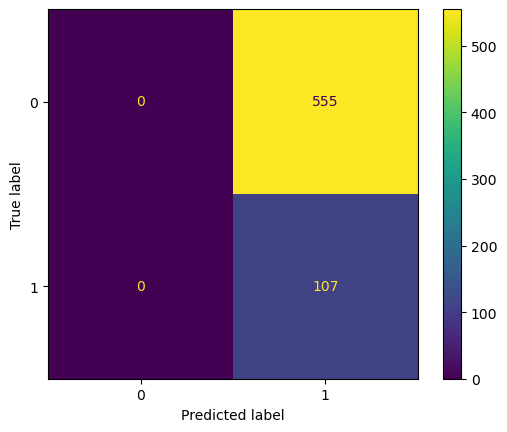

In [ ]:
cm_pe = confusion_matrix(y_test, y_pred_pe)
cmd_pe = ConfusionMatrixDisplay(confusion_matrix=cm_pe,
                       display_labels=[0,1])

cmd_pe.plot()
plt.show()

### Logistic Regression

In [ ]:
pipeline_lr = Pipeline(steps=[
    ('classifier', LogisticRegression())
])

In [ ]:
penalty = ['l2']
max_iter = [100,500,1000]


parameters_lr = dict(classifier__penalty = penalty,
                  classifier__max_iter = max_iter)

In [ ]:
lr_GS = GridSearchCV(pipeline_lr, parameters_lr)
lr_GS.fit(x_train, y_train)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

GridSearchCV(estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             param_grid={'classifier__max_iter': [100, 500, 1000],
                         'classifier__penalty': ['l2']})

In [ ]:
pd.DataFrame.from_dict(lr_GS.cv_results_).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_iter,param_classifier__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.023881,0.008111,0.001001,3.162980e-07,100,l2,"{'classifier__max_iter': 100, 'classifier__pen...",0.834667,0.848,0.838667,0.850467,0.851802,0.844721,0.006807,1
1,0.032030,0.015455,0.001000,1.007019e-06,500,l2,"{'classifier__max_iter': 500, 'classifier__pen...",0.840000,0.844,0.838667,0.842457,0.851802,0.843385,0.004600,2
2,0.030828,0.013715,0.001001,3.015783e-07,1000,l2,"{'classifier__max_iter': 1000, 'classifier__pe...",0.840000,0.844,0.838667,0.842457,0.851802,0.843385,0.004600,2


In [ ]:
lr = LogisticRegression(penalty='l2', max_iter = 100)

lr.fit(x_train, y_train)

score(lr, x_train, y_train)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Accuracy: 0.8412500249088336
F1 score: 0.04951472331895024
Precision: 0.36134453781512604
Recall: 0.02806736166800321
ROC AUC score: 0.7059784289733406


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

In [ ]:
y_pred_lr = lrc.predict(x_test)

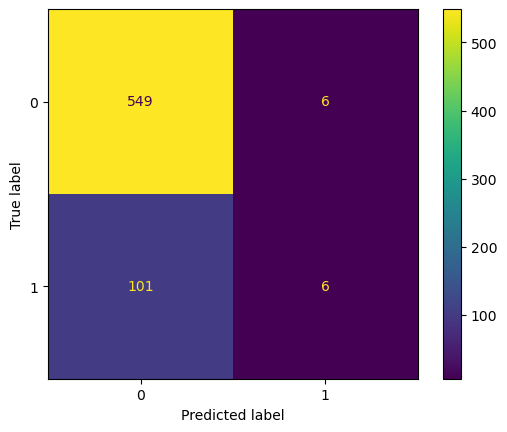

In [ ]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
cmd_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr,
                       display_labels=[0,1])

cmd_lr.plot()
plt.show()

# Analyse des résultats

# Conclusion
<div id="cc"></div>

On remarque que l'étude sur le fait de se sentir bien ou non a un fort impact sur les démissions
On remarque aussi que le nombre d'heure travaillée a aussi un certain impacte sur les démissions